In [ ]:
!pip install timm

In [1]:
import torch
import torchvision
import os
import cv2
import numpy as np
from torch import nn
from glob import glob
import timm
from tqdm import tqdm
import torch.nn.functional as F

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip /content/drive/MyDrive/close-up.zip

In [2]:
# cataract_paths = './images/close-up/cataract/*'
# cataract_paths = glob(cataract_paths)
# cataract_paths = cataract_paths[:2000]

cataract_paths = '/content/close-up copy/cataract/*'
cataract_paths = glob(cataract_paths)
cataract_paths = cataract_paths
cataract_paths

['/content/close-up copy/cataract/1238_3.jpg',
 '/content/close-up copy/cataract/163_1.jpg',
 '/content/close-up copy/cataract/216_1.jpg',
 '/content/close-up copy/cataract/47_3.jpg',
 '/content/close-up copy/cataract/947_1.jpg',
 '/content/close-up copy/cataract/941.jpg',
 '/content/close-up copy/cataract/915_1.jpg',
 '/content/close-up copy/cataract/409.jpg',
 '/content/close-up copy/cataract/469_3.jpg',
 '/content/close-up copy/cataract/138_1.jpg',
 '/content/close-up copy/cataract/1230.jpg',
 '/content/close-up copy/cataract/1239_0.jpg',
 '/content/close-up copy/cataract/1142_1.jpg',
 '/content/close-up copy/cataract/345_2.jpg',
 '/content/close-up copy/cataract/487_0.jpg',
 '/content/close-up copy/cataract/750_1.jpg',
 '/content/close-up copy/cataract/306_3.jpg',
 '/content/close-up copy/cataract/1044_3.jpg',
 '/content/close-up copy/cataract/4_2.jpg',
 '/content/close-up copy/cataract/301.jpg',
 '/content/close-up copy/cataract/250_1.jpg',
 '/content/close-up copy/cataract/29_1.j

In [3]:
# normal_paths = './images/close-up/normal/*'
# normal_paths = glob(normal_paths)
# normal_paths = normal_paths[:10000]

normal_paths = '/content/close-up copy/normal/*'
normal_paths = glob(normal_paths)
normal_paths = normal_paths

In [4]:
image_paths = normal_paths+cataract_paths

In [5]:
labels = []
images = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[3]
    image = image_path.split(os.path.sep)[4]
    labels.append(label)
    images.append(image)

In [6]:
np.unique(labels)

array(['cataract', 'normal'], dtype='<U8')

In [7]:
labels = np.array(labels, dtype='str')
label2pred = dict(zip(np.unique(labels), range(0, 2)))
pred2label = dict(zip(range(0, 2), np.unique(labels)))
n_classes = len(np.unique(labels))

In [8]:
class IrisDisease(torch.utils.data.Dataset):

    def __init__(self, image_paths, labels, transforms=None):
        super(IrisDisease, self).__init__()

        self.image_paths = image_paths
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (300, 300))

        label = self.labels[idx]
        label = label2pred[label]
        label = torch.tensor(label)

        if self.transforms:
            image = self.transforms(image)

        return image, label

In [9]:
device='cuda'

In [10]:
from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.25, random_state=42)

In [11]:
tr_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.CenterCrop(300),
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

In [12]:
train_dataset = IrisDisease(image_paths=train_image_paths, labels=train_labels, transforms=tr_transforms)
test_dataset = IrisDisease(image_paths=test_image_paths, labels=test_labels, transforms=val_transforms)
# train_dataset = Dataset(image_paths=image_paths, label=labels, transforms=torchvision.transforms.ToTensor())

In [13]:
len(train_dataset)

31762

In [14]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

normal


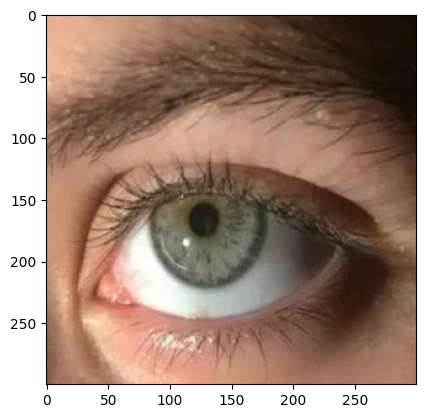

In [15]:
import matplotlib.pyplot as plt

plt.imshow(train_dataset[14][0].permute(1, 2, 0))
print(pred2label[train_dataset[14][1].item()])

In [16]:
class ClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [17]:
class EfficientNetB3(ClassificationBase):

    def __init__(self):
        super().__init__()

        self.network = timm.create_model('efficientnet_b3', pretrained=True)
        num_ftrs = self.network.classifier.in_features
        self.network.classifier = nn.Linear(num_ftrs, n_classes)


    def forward(self, batch):
        batch = batch.to(device)
        return torch.sigmoid(self.network(batch))


model = EfficientNetB3()

In [18]:
model = torch.compile(model)

In [19]:
def fit(epochs, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), 1e-4)
    for epoch in range(epochs):
        lrs = []
        loss = 0
        acc = 0
        for batch in tqdm.tqdm(train_loader):
            loss, acc = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print("Epoch [{}], loss: {:.4f}, acc: {:.4f}".format(epoch, loss, acc))
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
model = model.to(device)

In [25]:
model.eval()
evaluate(model, test_dataloader)
# Model_2: 0.9977
# Model_1: 1.0

{'val_loss': 0.31531083583831787, 'val_acc': 1.0}

In [ ]:
import tqdm
history = fit(10, model, train_dataloader, test_dataloader)

In [38]:
torch.save(model.state_dict(), 'model_2.pth')

In [ ]:
losses = []
accs = []
for i in range(len(history)):
  losses.append(history[i]['val_loss'])
  accs.append(history[i]['val_acc'])

In [ ]:
plt.plot(np.linspace(1, 10, 10).astype(int), losses)

In [ ]:
plt.plot(np.linspace(1, 10, 10).astype(int), accs)

In [23]:
model.load_state_dict(torch.load('model_1.pth', map_location=torch.device('cuda')))
model

OptimizedModule(
  (_orig_mod): EfficientNetB3(
    (network): EfficientNet(
      (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (bn1): BatchNormAct2d(
              40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (